<a href="https://colab.research.google.com/github/ArunK-ML/Project---Shopper-Spectrum-Customer-Segmentation-and-Product-Recommendations-in-E-Commerce/blob/main/Shopper_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🛒 Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce**

# **Step 1:Dataset Collection and understanding**

In [1]:
import pandas as pd
df = pd.read_csv('/content/online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.shape

(541909, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [5]:
df.duplicated().sum()

np.int64(5268)

# **Step 2: 📌 Data Preprocessing:**

**Handle Null Value**

In [6]:
df = df.dropna(subset=["CustomerID","Country"])

df["Description"] = df["Description"].fillna("No Description")

**Exclude cancelled invoices (InvoiceNo starting with 'C')**

In [7]:
# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

**Remove negative or zero quantities and prices**

In [8]:
# Keep only rows where Quantity > 0 and UnitPrice > 0
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

**DateTime DataType Conversation**

In [9]:
# Parse invoice date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Split into Date and Time
df["InvoiceDay"] = df["InvoiceDate"].dt.date
df["InvoiceTime"] = df["InvoiceDate"].dt.time


# **Feature Engineering**

In [10]:
from datetime import timedelta
# Add revenue column
df["Total_Amount"] = df["Quantity"] * df["UnitPrice"]

# Reference date = 1 day after last transaction in dataset
ref_date = df["InvoiceDate"].max() + timedelta(days=1)

# ==============================
# 📌 RFM Feature Engineering
# ==============================
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (ref_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Total_Amount", "sum")
).reset_index()

# Merge RFM values into the main transaction dataset
df = df.merge(rfm, on="CustomerID", how="left")

# **Step 3 :📌 Exploratory Data Analysis (EDA):**

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceTime,Total_Amount,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00,15.30,372,34,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,372,34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00,22.00,372,34,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,372,34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00,20.34,372,34,5391.21


In [12]:
df.shape

(397884, 14)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta



📌 Transaction volume by country (unique invoices):
Country
United Kingdom    16646
Germany             457
France              389
EIRE                260
Belgium              98
Netherlands          94
Spain                90
Portugal             57
Australia            57
Switzerland          51
Name: InvoiceNo, dtype: int64


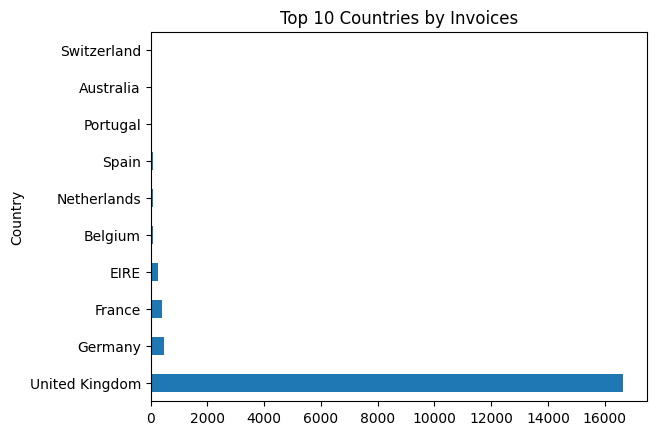

In [14]:
# -----------------------------
# 1) Transaction volume by country
# -----------------------------
tx_by_country = (
    df.groupby("Country")["InvoiceNo"]
      .nunique()
      .sort_values(ascending=False)
)
print("\n📌 Transaction volume by country (unique invoices):")
print(tx_by_country.head(10))

tx_by_country.head(10).plot(kind="barh", title="Top 10 Countries by Invoices")
plt.show()

In [15]:
# -----------------------------
# 2) Top-selling products
# -----------------------------
# By quantity
prod_qty = (
    df.groupby(["StockCode", "Description"])["Quantity"]
      .sum()
      .sort_values(ascending=False)
)
print("\n📌 Top 10 Products by Quantity Sold:")
print(prod_qty.head(10))

# By revenue
prod_rev = (
    df.groupby(["StockCode", "Description"])["Total_Amount"]
      .sum()
      .sort_values(ascending=False)
)
print("\n📌 Top 10 Products by Total Amount:")
print(prod_rev.head(10))


📌 Top 10 Products by Quantity Sold:
StockCode  Description                       
23843      PAPER CRAFT , LITTLE BIRDIE           80995
23166      MEDIUM CERAMIC TOP STORAGE JAR        77916
84077      WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
85099B     JUMBO BAG RED RETROSPOT               46181
85123A     WHITE HANGING HEART T-LIGHT HOLDER    36725
84879      ASSORTED COLOUR BIRD ORNAMENT         35362
21212      PACK OF 72 RETROSPOT CAKE CASES       33693
22197      POPCORN HOLDER                        30931
23084      RABBIT NIGHT LIGHT                    27202
22492      MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64

📌 Top 10 Products by Total Amount:
StockCode  Description                       
23843      PAPER CRAFT , LITTLE BIRDIE           168469.60
22423      REGENCY CAKESTAND 3 TIER              142592.95
85123A     WHITE HANGING HEART T-LIGHT HOLDER    100448.15
85099B     JUMBO BAG RED RETROSPOT                85220.78
23166      MEDIUM CE

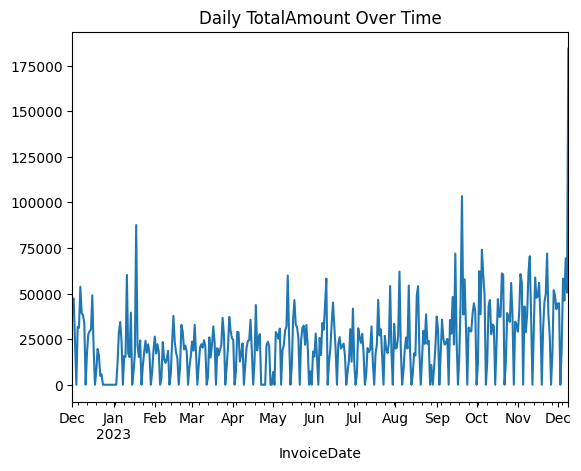

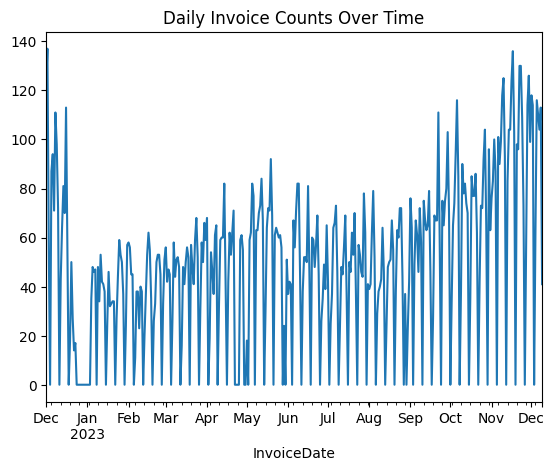

In [16]:
# -----------------------------
# 3) Purchase trends over time
# -----------------------------
daily = df.set_index("InvoiceDate").resample("D").agg(
    Revenue=("Total_Amount", "sum"),
    Invoices=("InvoiceNo", "nunique")
)

daily["Revenue"].plot(title="Daily TotalAmount Over Time")
plt.show()

daily["Invoices"].plot(title="Daily Invoice Counts Over Time")
plt.show()

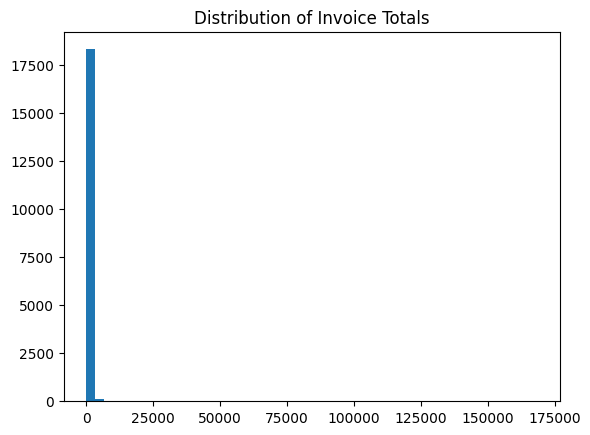

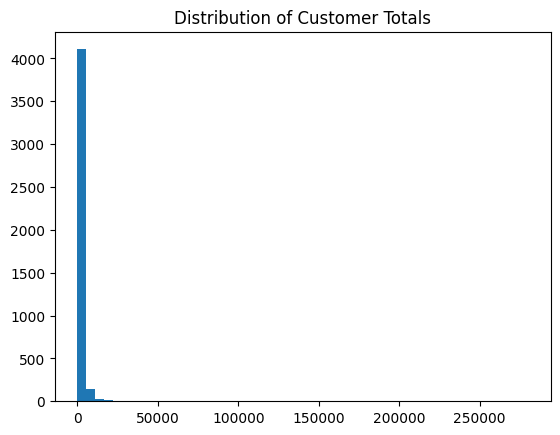

In [17]:
# -----------------------------
# 4) Monetary distribution
# -----------------------------
invoice_totals = df.groupby("InvoiceNo")["Total_Amount"].sum()
customer_totals = df.groupby("CustomerID")["Total_Amount"].sum()

plt.hist(invoice_totals, bins=50)
plt.title("Distribution of Invoice Totals")
plt.show()

plt.hist(customer_totals, bins=50)
plt.title("Distribution of Customer Totals")
plt.show()


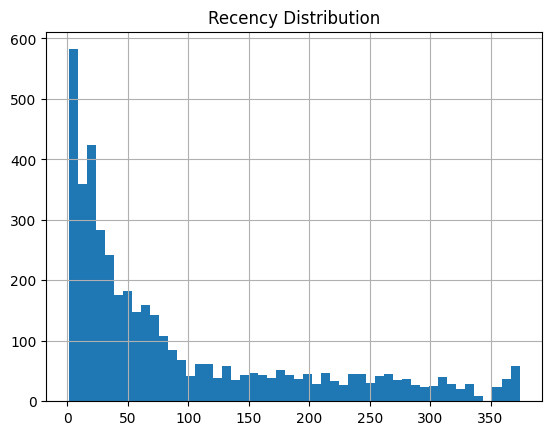

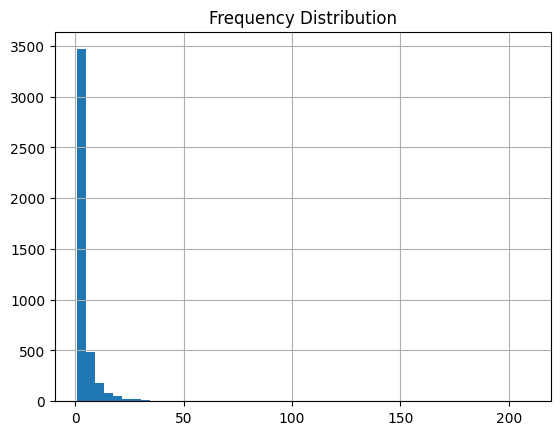

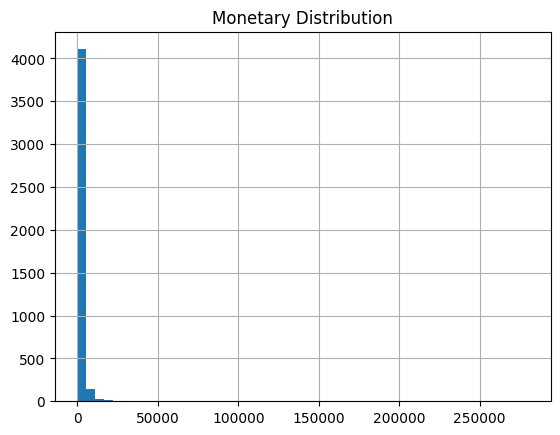

In [18]:
# -----------------------------
# 5) RFM analysis
# -----------------------------

# Histograms
rfm[["Recency"]].hist(bins=50)
plt.title("Recency Distribution")
plt.show()

rfm[["Frequency"]].hist(bins=50)
plt.title("Frequency Distribution")
plt.show()

rfm[["Monetary"]].hist(bins=50)
plt.title("Monetary Distribution")
plt.show()



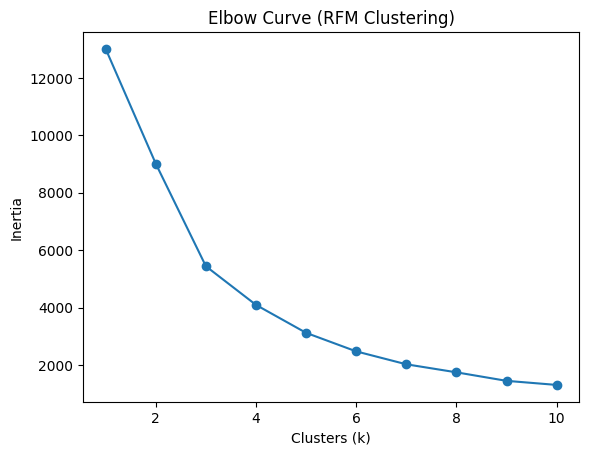


📌 Customer Cluster Profiles:
           CustomerID     Recency  Frequency       Monetary
Cluster                                                    
0        15289.128356   43.702685   3.682711    1359.049284
1        15347.791940  248.075914   1.552015     480.617480
2        15435.000000    7.384615  82.538462  127338.313846
3        15212.857843   15.500000  22.333333   12709.090490


In [19]:
# -----------------------------
# 6) Elbow curve for KMeans clustering
# -----------------------------
X = rfm[["Recency", "Frequency", "Monetary"]]
X_scaled = StandardScaler().fit_transform(X)

inertias = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 11), inertias, marker="o")
plt.title("Elbow Curve (RFM Clustering)")
plt.xlabel("Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Choose k=4 as example
km_final = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm["Cluster"] = km_final.fit_predict(X_scaled)

print("\n📌 Customer Cluster Profiles:")
print(rfm.groupby("Cluster").mean())

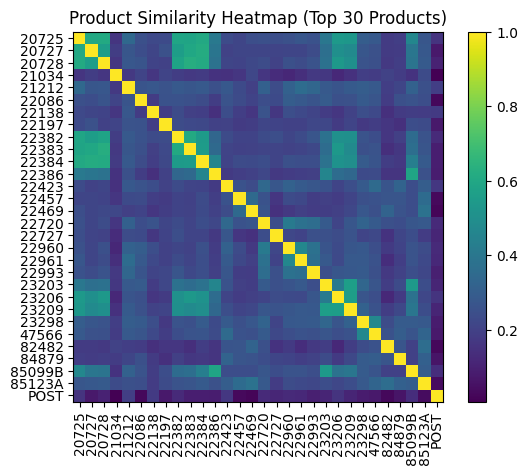

In [20]:
# -----------------------------
# 7) Product recommendation heatmap
# -----------------------------
# Pick top N products
topN = 30
top_prod_codes = (
    df.groupby("StockCode")["InvoiceNo"]
      .nunique()
      .sort_values(ascending=False)
      .head(topN)
      .index
)

df_top = df[df["StockCode"].isin(top_prod_codes)]
cust_prod = (
    df_top.assign(Buy=1)
          .pivot_table(index="CustomerID", columns="StockCode", values="Buy", aggfunc="max", fill_value=0)
)

sim_matrix = pd.DataFrame(
    cosine_similarity(cust_prod.T),
    index=cust_prod.columns,
    columns=cust_prod.columns
)

plt.imshow(sim_matrix, cmap="viridis")
plt.xticks(range(len(sim_matrix.columns)), sim_matrix.columns, rotation=90)
plt.yticks(range(len(sim_matrix.index)), sim_matrix.index)
plt.title("Product Similarity Heatmap (Top 30 Products)")
plt.colorbar()
plt.show()


# **Distribution Check**

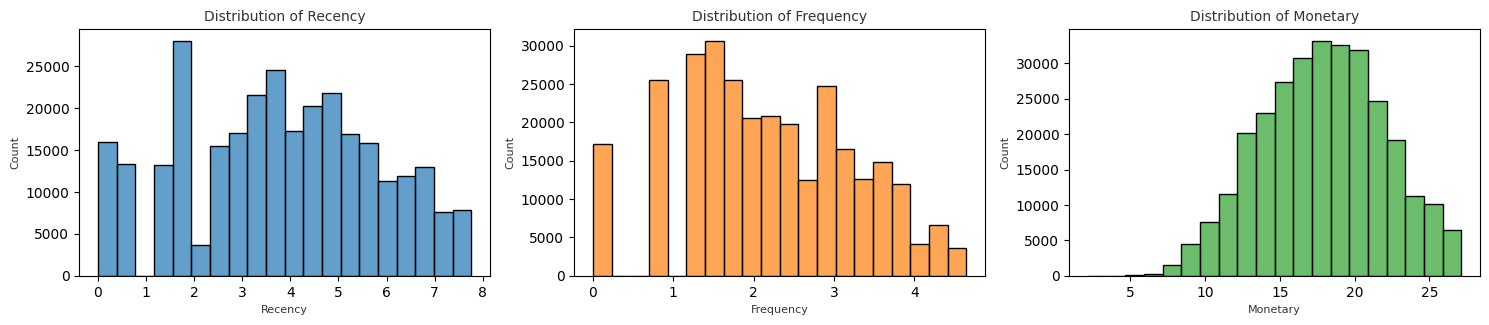

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Blue, Orange, Green, Red, Purple, Brown

plt.figure(figsize=(15, 18)) # size figure

# loop over each column to draw
numerical_cols = ["Recency", "Frequency", "Monetary"]
for i, col in enumerate(numerical_cols):
    plt.subplot(6, 3, i+1)  # (row, col, #plot) - Changed to 6 rows and 3 columns to accommodate all numerical columns
    sns.histplot(df[col], bins=20, color=colors[i % len(colors)], alpha=0.7) # histogram
    plt.title(f'Distribution of {col}', fontsize=10, color='#333333')
    plt.xlabel(col, fontsize=8, color='#333333')
    plt.ylabel('Count', fontsize=8, color='#333333')

plt.tight_layout()
plt.show()


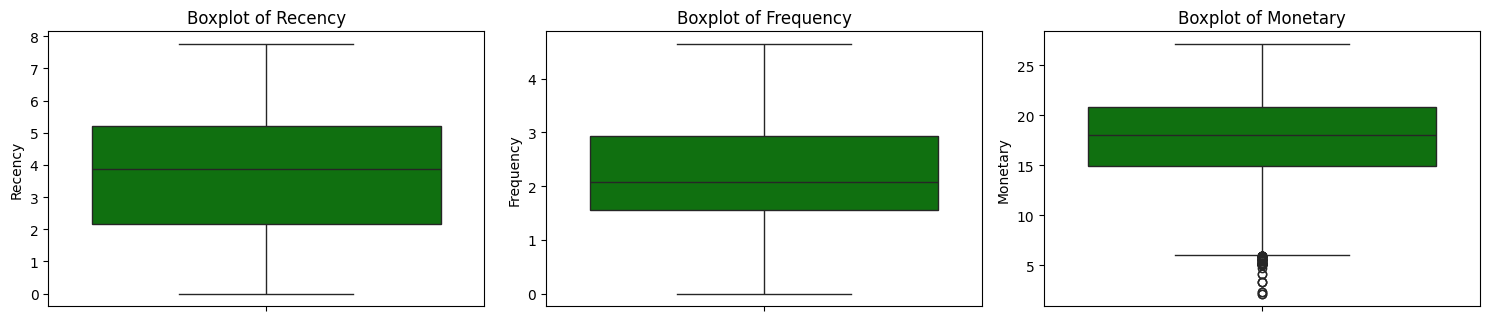

In [40]:
# Outliers

plt.figure(figsize=(15, 18)) # size figure
# loop over each columns
numerical_cols = ["Recency", "Frequency", "Monetary"]
for i, col in enumerate(numerical_cols):
    plt.subplot(6, 3, i+1)
    sns.boxplot(df[col], color='green')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, StandardScaler

# Select numeric columns
num_cols = ["Recency", "Frequency", "Monetary"]

# Make a copy of the numeric columns for transformation
df_boxcox = df[num_cols].copy()

# Apply Box-Cox transformation
for col in num_cols:
    # Ensure all values are positive
    min_val = df_boxcox[col].min()
    if min_val <= 0:
        df_boxcox[col] = df_boxcox[col] + abs(min_val) + 1e-6  # shift to positive

    # Apply Box-Cox
    df_boxcox[col], _ = boxcox(df_boxcox[col])

# Save back the transformed columns into the original df
df[num_cols] = df_boxcox

In [34]:
# ----------------------------
#    Handle Outliers (IQR Method)
# ----------------------------
def remove_outliers_iqr(data):
    df_out = data.copy()
    num_cols = ["Recency", "Frequency", "Monetary"]

    # Initialize a mask with all True
    mask = np.ones(len(df_out), dtype=bool)

    for col in num_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= (df_out[col] >= lower) & (df_out[col] <= upper)  # combine masks

    df_out = df_out[mask]
    return df_out

# Apply function
df = remove_outliers_iqr(df)



# **Step 4 : 📌 Clustering Methodology:**

**2️⃣ Standardize/Normalize the RFM values**

In [41]:
from sklearn.preprocessing import StandardScaler

# Select only the RFM columns
rfm_values = df[["Recency", "Frequency", "Monetary"]]

# Standardize (mean=0, std=1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)

# Store in a new DataFrame with same index
rfm_scaled_df = pd.DataFrame(rfm_scaled,
                             columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"],
                             index=df.index)

# Concatenate back with original RFM
df = pd.concat([df, rfm_scaled_df], axis=1)

# Preview
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceTime,...,Recency,Frequency,Monetary,Recency_scaled,Frequency_scaled,Monetary_scaled,KMeans_Cluster,Recency_scaled,Frequency_scaled,Monetary_scaled
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom,2022-12-01,08:34:00,...,5.08492,2.79061,19.233329,-0.139383,-0.235023,-0.264656,0,0.649607,0.560314,0.325378
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2022-12-01 08:34:00,2.10,13047.0,United Kingdom,2022-12-01,08:34:00,...,5.08492,2.79061,19.233329,-0.139383,-0.235023,-0.264656,0,0.649607,0.560314,0.325378
11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2022-12-01 08:34:00,2.10,13047.0,United Kingdom,2022-12-01,08:34:00,...,5.08492,2.79061,19.233329,-0.139383,-0.235023,-0.264656,0,0.649607,0.560314,0.325378
12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2022-12-01 08:34:00,3.75,13047.0,United Kingdom,2022-12-01,08:34:00,...,5.08492,2.79061,19.233329,-0.139383,-0.235023,-0.264656,0,0.649607,0.560314,0.325378
13,536367,22310,IVORY KNITTED MUG COSY,6,2022-12-01 08:34:00,1.65,13047.0,United Kingdom,2022-12-01,08:34:00,...,5.08492,2.79061,19.233329,-0.139383,-0.235023,-0.264656,0,0.649607,0.560314,0.325378


# **3️⃣ Choose Clustering Algorithm (KMeans, DBScan, Hierarchial etc)**

**1. KMeans (most common for RFM)**

In [42]:
from sklearn.cluster import KMeans

# Use the scaled RFM values
X = df[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]]

# Fit KMeans (example with k=4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(X)

print(df.groupby("KMeans_Cluster")[["Recency", "Frequency", "Monetary"]].mean())


                 Recency  Frequency   Monetary
KMeans_Cluster                                
0               2.113688   3.525658  22.498431
1               5.235266   2.260972  19.140421
2               5.462264   0.870941  12.937171
3               2.184979   2.011837  16.709547


**2. DBSCAN (density-based clustering)**

In [23]:
# from sklearn.cluster import DBSCAN

# db = DBSCAN(eps=1.5, min_samples=5)  # tune eps & min_samples
# df["DBSCAN_Cluster"] = db.fit_predict(X)

# print(df["DBSCAN_Cluster"].value_counts())


**3. Hierarchical Clustering (Agglomerative)**

In [24]:
# from sklearn.cluster import AgglomerativeClustering

# hc = AgglomerativeClustering(n_clusters=4, linkage="ward")
# df["HC_Cluster"] = hc.fit_predict(X)

# print(df.groupby("HC_Cluster")[["Recency", "Frequency", "Monetary"]].mean())


In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selected Scaled Column
X = df[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]]

# Fit the model
model = KMeans(n_clusters=4, random_state=42,  n_init=10)
model.fit(X)

# Predict cluster labels
group = model.predict(X)

# Calculate Silhouette Score
score = silhouette_score(X, group)

print("Silhouette Score:", round(score, 3))

Silhouette Score: 0.315


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selected Scaled Column
X = df[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]]

# Fit the model
model = KMeans(n_clusters=4, max_iter=200, tol=1e-3, n_init=10)
model.fit(X)

# Predict cluster labels
group = model.predict(X)

# Calculate Silhouette Score
score = silhouette_score(X, group)

print("Silhouette Score:", round(score, 3))

Silhouette Score: 0.315


In [ ]:
# Ways to speed it up

# Use a sample of the data

# df_sample = df.sample(frac=0.1, random_state=42)


# 10–20% of data is usually enough to get a clear elbow.

# Reduce dimensions

# Apply PCA before K-means if you have many features:

# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# df_reduced = pca.fit_transform(df_scaled)


# Increase tolerance or reduce iterations

# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=k, max_iter=200, tol=1e-3, n_init=10)


# Use MiniBatchKMeans

# Works faster on large datasets by using mini-batches instead of the full dataset:

# from sklearn.cluster import MiniBatchKMeans
# kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000)


# Handle outliers first

# Removing extreme points can make centroids converge faster.

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import plotly.express as px
# import pandas as pd

# # List to store silhouette scores
# silhouette_scores = []

# # Loop from k=2 to a sensible max value
# max_k = 11  # Limit for performance

# for i in range(2, max_k):
#     model = KMeans(n_clusters=i, random_state=42)
#     group = model.fit_predict(df.iloc[:, :-1])
#     score = silhouette_score(df.iloc[:, :-1], group)
#     silhouette_scores.append(score)

# # Prepare DataFrame for Plotly
# results_df = pd.DataFrame({
#     "Number of Clusters (k)": list(range(2, max_k )),
#     "Silhouette Score": silhouette_scores
# })

# # Plot using Plotly Express
# fig = px.line(
#     results_df,
#     x="Number of Clusters (k)",
#     y="Silhouette Score",
#     markers=True,
#     title="Silhouette Score for Different Values of k"
# )

# fig.update_layout(
#     xaxis_title="Number of Clusters (k)",
#     yaxis_title="Silhouette Score",
#     template="plotly_white"
# )

# fig.show()


In [ ]:
# import pandas as pd
# from sklearn.cluster import MiniBatchKMeans
# import hdbscan
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ----------------------------
# # 1️⃣ MiniBatch K-Means
# # ----------------------------
# k = 5  # Number of clusters (choose based on Elbow method)
# mbk = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=42)
# df_scaled['MBK_Cluster'] = mbk.fit_predict(df_scaled)

# # Plot MiniBatch K-Means clusters (pairplot for RFM)
# sns.pairplot(df_scaled, vars=['Recency', 'Frequency', 'Monetary'], hue='MBK_Cluster', palette='Set2')
# plt.suptitle("MiniBatch K-Means Clusters", y=1.02)
# plt.show()

# # ----------------------------
# # 2️⃣ HDBSCAN
# # ----------------------------
# # Minimum cluster size (adjust based on your dataset)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
# df_scaled['HDBSCAN_Cluster'] = clusterer.fit_predict(df_scaled[['Recency', 'Frequency', 'Monetary']])

# # Plot HDBSCAN clusters
# sns.pairplot(df_scaled, vars=['Recency', 'Frequency', 'Monetary'], hue='HDBSCAN_Cluster', palette='Set1')
# plt.suptitle("HDBSCAN Clusters", y=1.02)
# plt.show()

# # ----------------------------
# # Optional: Check number of clusters
# # ----------------------------
# print("MiniBatch K-Means cluster counts:")
# print(df_scaled['MBK_Cluster'].value_counts())

# print("\nHDBSCAN cluster counts (-1 = noise):")
# print(df_scaled['HDBSCAN_Cluster'].value_counts())


In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import pandas as pd
# import plotly.express as px

# # Prepare lists
# silhouette_scores = []
# wcss = []
# k_values = list(range(2, min(20, len(df) - 1) + 1))

# # Loop through values of k
# for k in k_values:
#     model = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = model.fit_predict(df.iloc[:, :-1])

#     silhouette_scores.append(silhouette_score(df.iloc[:, :-1], labels))
#     wcss.append(model.inertia_)

# # Normalize both metrics for a fair comparison
# silhouette_norm = (pd.Series(silhouette_scores) - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores))
# wcss_norm = (pd.Series(wcss) - min(wcss)) / (max(wcss) - min(wcss))

# # Combine into a DataFrame for Plotly Express
# metrics_df = pd.DataFrame({
#     'Number of Clusters (k)': k_values * 2,
#     'Score': list(silhouette_norm) + list(wcss_norm),
#     'Metric': ['Silhouette Score'] * len(k_values) + ['WCSS (Normalized)'] * len(k_values)
# })

# # Plot with Plotly Express
# fig = px.line(
#     metrics_df,
#     x='Number of Clusters (k)',
#     y='Score',
#     color='Metric',
#     markers=True,
#     title='Silhouette Score vs WCSS (Normalized) using Plotly Express'
# )

# fig.update_layout(
#     yaxis_title='Normalized Score',
#     xaxis_title='Number of Clusters (k)',
#     template='plotly_white'
# )

# fig.show()


**5️⃣ Run Clustering**

In [ ]:
# from sklearn.cluster import KMeans

# # ==============================
# # 📌 Run KMeans Clustering
# # ==============================

# # Choose number of clusters
# best_k = 4

# kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# df["Cluster"] = kmeans.fit_predict(
#     df[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]]
# )

# # ==============================
# # 📊 Cluster Profiling
# # ==============================
# cluster_profile = (
#     df.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
#           .mean()
#           .round(2)
# )
# print("\n📌 Customer Cluster Profiles:")
# print(cluster_profile)

# # Cluster sizes
# print("\n📌 Number of Customers per Cluster:")
# print(df["Cluster"].value_counts())

# # Optional visualization
# import matplotlib.pyplot as plt

# plt.scatter(df["Recency_scaled"], df["Monetary_scaled"],
#             c=df["Cluster"], cmap="viridis", alpha=0.5)
# plt.xlabel("Recency (scaled)")
# plt.ylabel("Monetary (scaled)")
# plt.title("Customer Clusters (KMeans)")
# plt.show()


In [ ]:
# # ==============================
# # 📌 Label Clusters into Segments
# # ==============================

# # Calculate mean RFM values per cluster
# cluster_profile = (
#     rfm_df.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
#           .mean()
#           .round(2)
# )

# print("📌 Cluster Profiles:\n", cluster_profile)

# # Function to assign segment labels based on RFM values
# def label_segment(row):
#     if row["Recency"] < cluster_profile["Recency"].median() and \
#        row["Frequency"] > cluster_profile["Frequency"].median() and \
#        row["Monetary"] > cluster_profile["Monetary"].median():
#         return "High-Value"   # recent, frequent, big spenders

#     elif row["Frequency"] > cluster_profile["Frequency"].median() and \
#          row["Monetary"] > cluster_profile["Monetary"].median():
#         return "Regular"      # steady purchasers

#     elif row["Frequency"] < cluster_profile["Frequency"].median() and \
#          row["Monetary"] < cluster_profile["Monetary"].median() and \
#          row["Recency"] > cluster_profile["Recency"].median():
#         return "At-Risk"      # not purchased in long time

#     else:
#         return "Occasional"   # rare/occasional purchasers

# # Apply segment labeling
# rfm_df["Segment"] = rfm_df.apply(label_segment, axis=1)

# # ==============================
# # 📊 Segment Distribution
# # ==============================
# print("\n📌 Segment Distribution:")
# print(rfm_df["Segment"].value_counts())

# # Segment-level RFM averages
# segment_profile = (
#     rfm_df.groupby("Segment")[["Recency", "Frequency", "Monetary"]]
#           .mean()
#           .round(2)
# )
# print("\n📌 Segment Profiles:\n", segment_profile)


6️⃣ Visualize the clusters using a scatter plot or 3D plot of RFM scores.
**bold text**

In [ ]:
# # 2D Scatter Plots (pairwise RFM)

# import matplotlib.pyplot as plt

# # 2D Scatter: Frequency vs Monetary
# plt.figure(figsize=(7,5))
# plt.scatter(rfm_df["Frequency_scaled"], rfm_df["Monetary_scaled"],
#             c=rfm_df["Cluster"], cmap="viridis", alpha=0.6)
# plt.xlabel("Frequency (scaled)")
# plt.ylabel("Monetary (scaled)")
# plt.title("Customer Clusters (Frequency vs Monetary)")
# plt.colorbar(label="Cluster")
# plt.show()

# # 2D Scatter: Recency vs Monetary
# plt.figure(figsize=(7,5))
# plt.scatter(rfm_df["Recency_scaled"], rfm_df["Monetary_scaled"],
#             c=rfm_df["Cluster"], cmap="viridis", alpha=0.6)
# plt.xlabel("Recency (scaled)")
# plt.ylabel("Monetary (scaled)")
# plt.title("Customer Clusters (Recency vs Monetary)")
# plt.colorbar(label="Cluster")
# plt.show()

# # 2D Scatter: Recency vs Frequency
# plt.figure(figsize=(7,5))
# plt.scatter(rfm_df["Recency_scaled"], rfm_df["Frequency_scaled"],
#             c=rfm_df["Cluster"], cmap="viridis", alpha=0.6)
# plt.xlabel("Recency (scaled)")
# plt.ylabel("Frequency (scaled)")
# plt.title("Customer Clusters (Recency vs Frequency)")
# plt.colorbar(label="Cluster")
# plt.show()


In [ ]:
# # 3D Scatter Plot (RFM together)

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(rfm_df["Recency_scaled"],
#            rfm_df["Frequency_scaled"],
#            rfm_df["Monetary_scaled"],
#            c=rfm_df["Cluster"], cmap="viridis", alpha=0.6)

# ax.set_xlabel("Recency (scaled)")
# ax.set_ylabel("Frequency (scaled)")
# ax.set_zlabel("Monetary (scaled)")
# ax.set_title("3D Customer Clusters (RFM)")
# plt.show()
